In [1]:
import geopandas
import pandas
import pathlib
import numpy
import matplotlib
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
sampling_resolution = 10
threshold = 2.5

## Load in results
### Widths and slopes

In [3]:
width_file = pathlib.Path(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\westport\caches\6311000000_test\final_transect_values.geojson")
rec_main_channel_file = pathlib.Path(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\westport\caches\6311000000_test\rec_main_channel.geojson")
widths = geopandas.read_file(width_file)
main_channel = geopandas.read_file(rec_main_channel_file)

### Slopes and Flows

In [4]:
mannings_file = pathlib.Path(r"C:\Users\pearsonra\Documents\data\river_bathemetry\mannings_n\bathy.csv.gz")
mannings = pandas.read_csv(mannings_file)

### Measured cross sections

In [5]:
cross_section_file = pathlib.Path(r"C:/Users/pearsonra/Documents/data/river_bathemetry/sections/Westport/3738_Buller_River_October_2021/3738_Buller_River_October_2021.shp")
cross_section_file_2 = pathlib.Path(r"C:/Users/pearsonra/Documents/data/river_bathemetry/sections/Westport/3738 - Buller River October 2021.xls")
cross_sections = geopandas.read_file(cross_section_file)
cross_section_elevation_label = 'Elevation'
cross_section_name_label = 'Name'

Manually specify order of sections and manually remove sections across side-channels. Note could try automate by working down the centreline and checking each section for any intersections with the measured sections

In [6]:
ordered_measured_sections = ['Section1', 'Section2', 'Section2A', 'Section2B', 'Section3', 'Section3A', 'Section4', 'Section5',
                             'Section6', 'Section7', 'Section8', 'Section9', 'Section10', 'Section11', 'Section12', 'Section13',
                             'Section14', 'Section15', 'Section16', 'Section21', 'Section22', 'Section23', 'Section24', 'Section25',
                             'Section26']

Note that the data is noisey and four sections are on a side channel: sections 17, 18, 19, 20
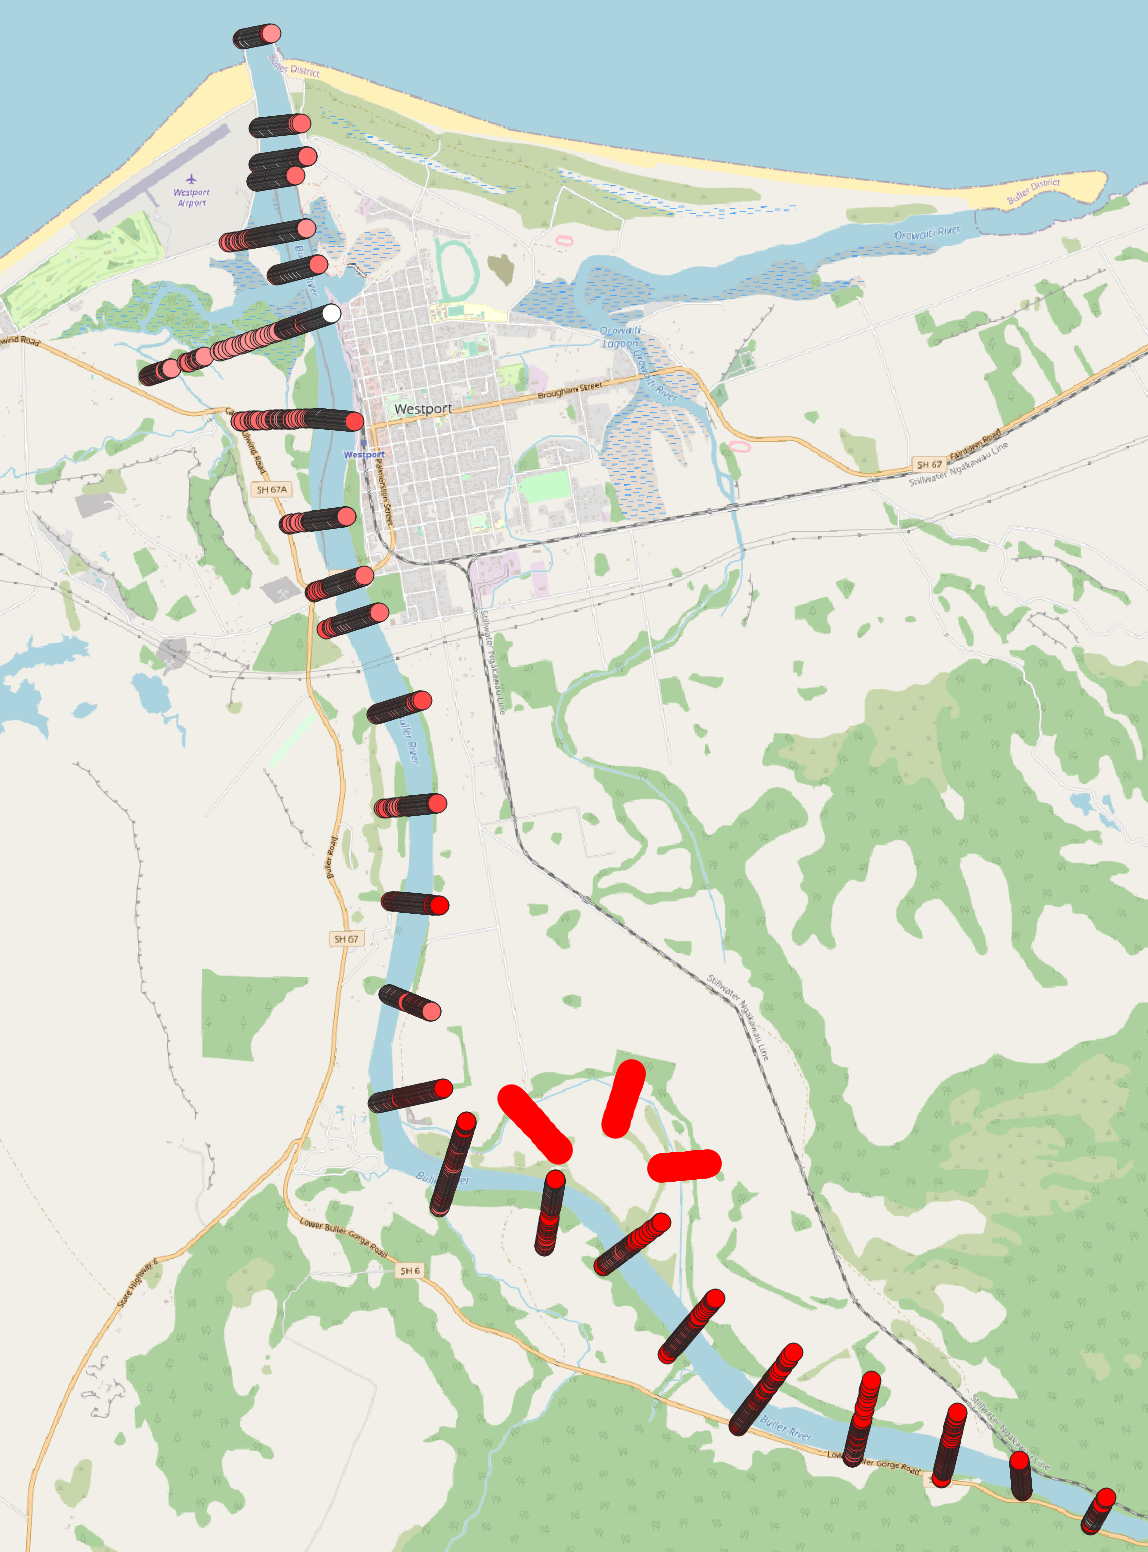

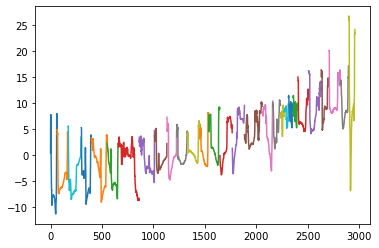

In [7]:
cross_sections.groupby(cross_section_name_label)[cross_section_elevation_label].plot();

### Local datum conversion

In [65]:
local_datum_file = pathlib.Path(r"C:\Users\pearsonra\Documents\data\local_datums\lds-lyttelton-1937-to-nzvd2016-conversion-raster-GTiff\lyttelton-1937-to-nzvd2016-conversion-raster.tif")

In [66]:
import rioxarray
with rioxarray.rioxarray.open_rasterio(local_datum_file, masked=True) as local_vertical_datum:
            local_vertical_datum.load()

# Translate the samples to correct reach

In [67]:
widths['nzsegment'] = numpy.zeros(len(widths['widths']), dtype=int) * -1
for i, row in main_channel.iterrows():
    widths.loc[widths.intersects(row.geometry), ('nzsegment')] = row['nzsegment']

# Add the flows and manning's n to the widths table

In [68]:
slope_name = 'slope_mean_3.0km'
min_z_name = 'min_z_centre_unimodal_mean_2.0km'
width_name = 'widths_mean_0.25km'

In [69]:
key_parameters = widths[['nzsegment', slope_name, width_name, 'geometry', min_z_name, 'min_z_centre_unimodal']]
key_parameters = key_parameters[key_parameters['nzsegment'] != 0]

In [70]:
key_parameters['mannings_n'] = numpy.zeros(len(key_parameters['nzsegment']), dtype=int)
key_parameters['flow'] = numpy.zeros(len(key_parameters['nzsegment']), dtype=int)
for nzsegment in key_parameters['nzsegment'].unique():
    key_parameters.loc[key_parameters['nzsegment'] == nzsegment, ('mannings_n')] = mannings[mannings['nzsegment'] == nzsegment]['n'].unique()[0]
    key_parameters.loc[key_parameters['nzsegment'] == nzsegment, ('flow')] = mannings[mannings['nzsegment'] == nzsegment]['flow'].unique()[0]

## Scale flow to reflect the average Te Kuha guage at the time of LiDAR flight

In [71]:
mean_guage_during_lidar_flight = 177.7813
guage_scale_factor = mean_guage_during_lidar_flight / key_parameters[['flow']].min().min()
key_parameters['flow'] = key_parameters['flow'] * guage_scale_factor

<AxesSubplot:>

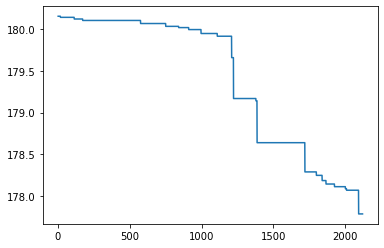

In [72]:
key_parameters['flow'].plot()

Check nzsegments look reasonable

<AxesSubplot:>

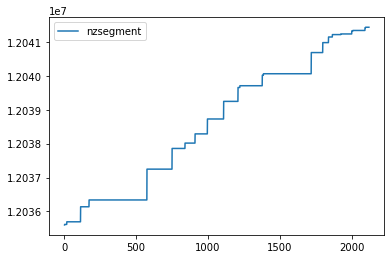

In [73]:
key_parameters[['nzsegment']].plot()

## Calculate depth

Depths estimated using the Uniform Flow Theory

In [74]:
key_parameters['depth_Neal_et_al'] = (key_parameters['mannings_n'] * key_parameters['flow'] \
                                      / (numpy.sqrt(key_parameters[slope_name])
                                         * key_parameters[width_name])) ** (3/5) - threshold

In [75]:
a = 0.745
b = 0.305
K_0 = 6.16

Depths estimated using the conceptual multivariate regression approach

In [76]:
key_parameters['depth_Smart_et_al'] = (key_parameters['flow'] / (K_0 * key_parameters[width_name] 
                                                                 * key_parameters[slope_name] ** b)) ** (1 / (1+a)) - threshold

## Plot results
Include plots of each parameter - Manning's n, flow, depth and slope - used to calculate depth

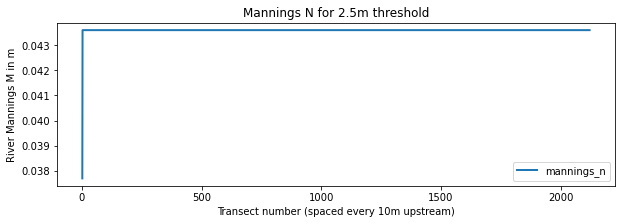

In [77]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['mannings_n']].plot(ax=ax, linewidth=2)
ax.set(title=f"Mannings N for {threshold}m threshold")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River Mannings M in m");

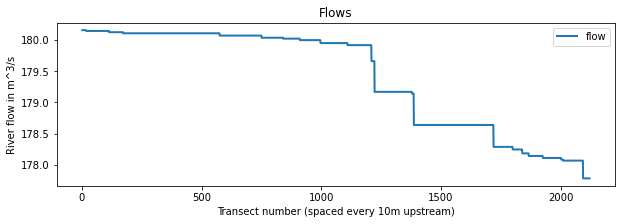

In [78]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['flow']].plot(ax=ax, linewidth=2)
ax.set(title=f"Flows")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River flow in m^3/s");

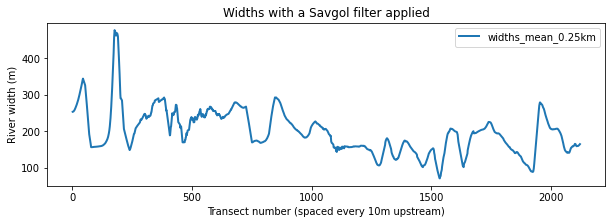

In [79]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[[width_name]].plot(ax=ax, linewidth=2)
ax.set(title=f"Widths with a Savgol filter applied")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River width (m)");

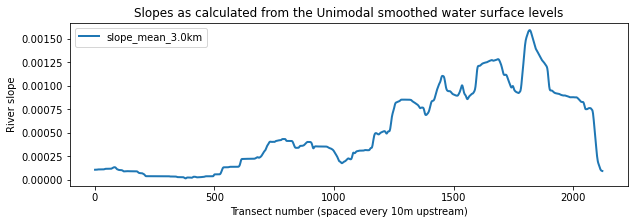

In [80]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[[slope_name]].plot(ax=ax, linewidth=2)
ax.set(title=f"Slopes as calculated from the Unimodal smoothed water surface levels")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River slope");

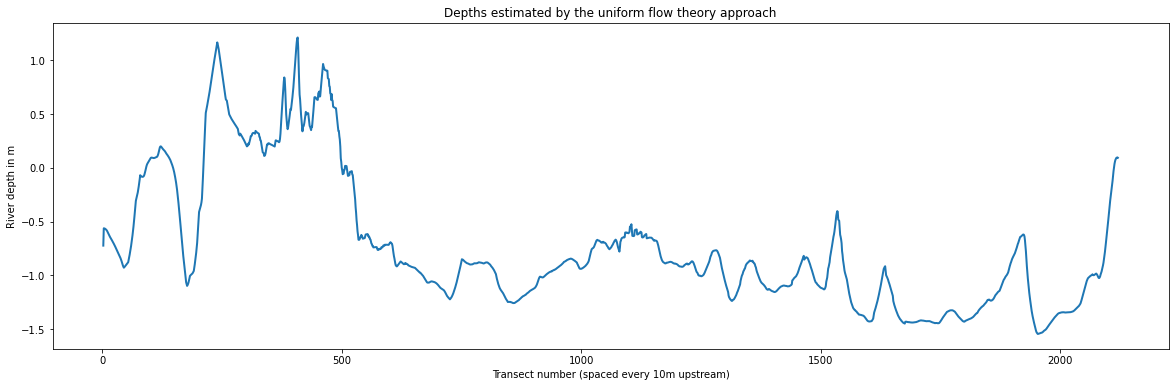

In [81]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
key_parameters['depth_Neal_et_al'].plot(ax=ax, linewidth=2)
ax.set(title=f"Depths estimated by the uniform flow theory approach")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");

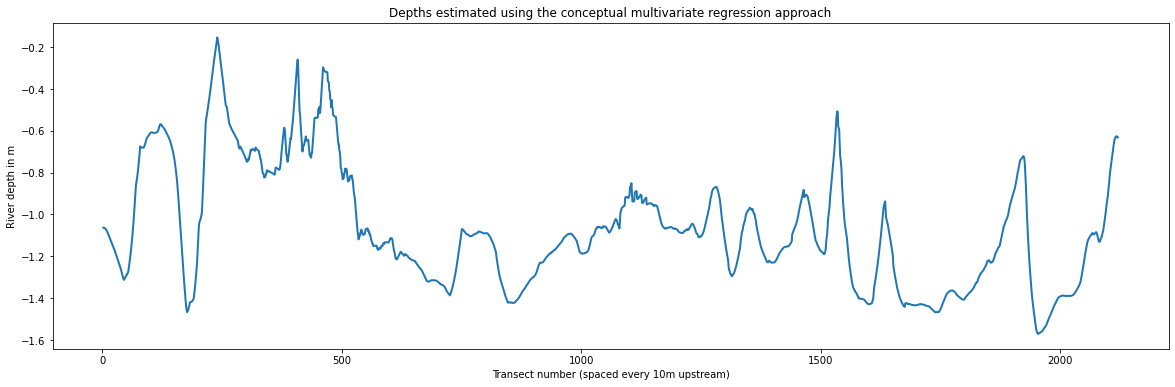

In [82]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
key_parameters['depth_Smart_et_al'].plot(ax=ax, linewidth=2)
ax.set(title="Depths estimated using the conceptual multivariate regression approach")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");

## Measured cross sections

Plot minimum height (i.e height of the bed)

Add the LVD conversion

In [83]:
def get_lvd_conversion(geometry, local_vertical_datum):
    return local_vertical_datum.sel({'x': [geometry.x], 'y': [geometry.y]}, method='nearest').data[0,0,0]

cross_sections['lvd_conversion'] = cross_sections.apply(lambda row: get_lvd_conversion(row.geometry, local_vertical_datum), axis=1)
cross_sections['z_2016'] = cross_sections[cross_section_elevation_label] - cross_sections['lvd_conversion']

Pull out the centre point for each section - for idntification of the nearest sampled transect

In [84]:
section_centres = {'Section': [], 'geometry': []}
for section in ordered_measured_sections:
    section_centre = cross_sections[cross_sections[cross_section_name_label] == section].iloc[round(len(cross_sections[cross_sections[cross_section_name_label] == section])/2)]
    section_centres['Section'].append(section_centre[cross_section_name_label])
    section_centres['geometry'].append(section_centre['geometry'])
section_centres = geopandas.GeoDataFrame(section_centres, crs=main_channel.crs)

Cycle through each section identifying the nearest section in the key parameters

In [85]:
nearest_transect = numpy.zeros_like(key_parameters[slope_name], dtype=bool)
for index, row in section_centres.iterrows():
    nearest_transect[key_parameters.distance(row.geometry).argmin()] = True

nearest_key_parameters = key_parameters[nearest_transect]

### Compare the depth results for different min_z values

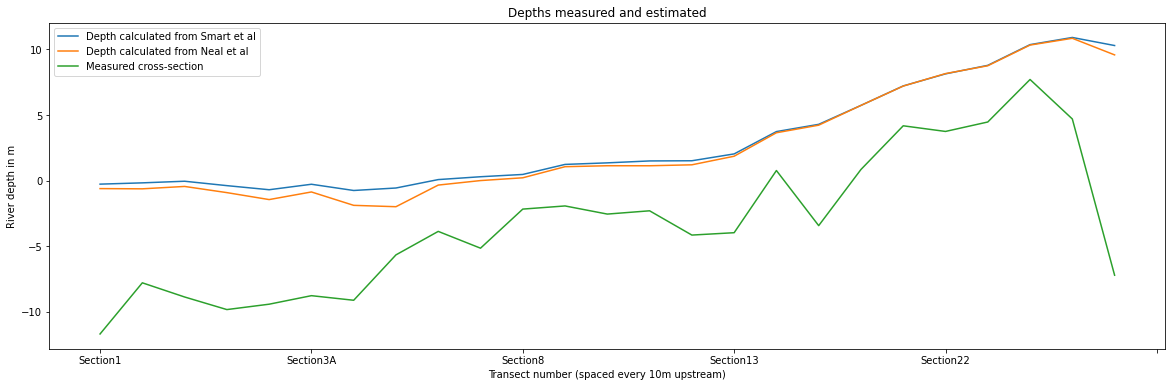

In [86]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
(nearest_key_parameters[min_z_name]-nearest_key_parameters['depth_Smart_et_al']).reset_index(drop=True).plot(label='Depth calculated from Smart et al')
(nearest_key_parameters[min_z_name]-nearest_key_parameters['depth_Neal_et_al']).reset_index(drop=True).plot(label='Depth calculated from Neal et al')
cross_sections.groupby([cross_section_name_label])['z_2016'].min().reindex(ordered_measured_sections).plot(label='Measured cross-section')
ax.set(title="Depths measured and estimated")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");
matplotlib.pyplot.legend()

### Plot other values
* Widths - nearest the measured cross sections
* Measured cross section depth compared to water surface height

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
nearest_key_parameters[['widths_Savgol']].reset_index(drop=True).plot(ax=ax)
ax.set(title="Estimated width nearest to measured cross section")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"Channel width (m)");
matplotlib.pyplot.legend()

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
nearest_key_parameters[['min_z_centre_unimodal', 'min_z_centre_unimodal_0.5km_rolling_mean', 'min_z_centre']].reset_index(drop=True).plot(ax=ax)
cross_sections.groupby('Section')['z_2016'].min().reset_index(drop=True).plot(ax=ax, label='Measured cross-section depth')
ax.set(title="Measured depth compared to estimated water surface elevation")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"Elevation (m)");
matplotlib.pyplot.legend()

### Plots exploring the change to width to produce an expected bed elevation

In [ ]:
fudge_factor = 2
depth_wider = (nearest_key_parameters['mannings_n'] * nearest_key_parameters['flow'] / (numpy.sqrt(nearest_key_parameters['slope']) * nearest_key_parameters['widths_Savgol'] * fudge_factor)) ** (3/5) - threshold

f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
(nearest_key_parameters['min_z_centre_unimodal']-depth_wider).reset_index(drop=True).plot(label='Calculated from unimodal min_z')
(nearest_key_parameters['min_z_centre_unimodal_0.5km_rolling_mean'] - depth_wider).reset_index(drop=True).plot(label='Calculated from smooth unimodal min_z')
(nearest_key_parameters['min_z_centre']-depth_wider).reset_index(drop=True).plot(label='Calculated from min_z')
cross_sections.groupby('Section')['z_2016'].min().reset_index(drop=True).plot(label='Measured cross-section')
ax.set(title=f"Depths estimated using the Uniform Flow Throery approach with width mutiplier of {fudge_factor}")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");
matplotlib.pyplot.legend()

In [ ]:
fudge_factor = 2
depth_wider = (nearest_key_parameters['flow'] / (K_0 * nearest_key_parameters['widths_Savgol'] * fudge_factor * nearest_key_parameters['slope'] ** b)) ** (1 / (1+a)) - threshold

f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
(nearest_key_parameters['min_z_centre_unimodal']-depth_wider).reset_index(drop=True).plot(label='Calculated from unimodal min_z')
(nearest_key_parameters['min_z_centre_unimodal_0.5km_rolling_mean']-depth_wider).reset_index(drop=True).plot(label='Calculated from smooth unimodal min_z')
(nearest_key_parameters['min_z_centre']-depth_wider).reset_index(drop=True).plot(label='Calculated from min_z')
cross_sections.groupby('Section')['z_2016'].min().reset_index(drop=True).plot(label='Measured cross-section')
ax.set(title=f"Depths estimated using the conceptual multivariate regression approach with width mutiplier of {fudge_factor}")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");
matplotlib.pyplot.legend()

### Mics plots for reference: 
Water levels for 10m spaced transects

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['min_z_centre_unimodal', 'min_z_centre_unimodal_0.5km_rolling_mean', 'min_z_centre']].plot(ax=ax, linewidth=2)
ax.set(title=f"Water surface as calculated from sampled transects")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"Water surface elevation");

Widths at 10m spacing

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['widths_Savgol']].plot(ax=ax, linewidth=2)
ax.set(title="Channel width (m)")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"Estimated channel width");